In [1]:
# Mask R-CNN reference code
# https://www.cnblogs.com/hellcat/p/9987442.html


# the reference web of Colab with google drive : https://www.jianshu.com/p/ce2e63d1c10c
# 戴入檔案的方式， 
# COLAB  0:從Local端的路徑  
#       1:從Google Drive 中載入 

import os

IS_COLAB = 0

if IS_COLAB == 1:
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse
  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p drive
  !google-drive-ocamlfuse drive

  # 此处为google drive中的文件路径,drive为之前指定的工作根目录，要加上
  os.chdir("drive/Colab Notebooks/breast_mask_rcnn") 
  !ls

In [2]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt


from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

%matplotlib inline 

import tensorflow as tf
device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
#  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Using TensorFlow backend.


Found GPU at: 


# Create Model and Load Trained Weights

In [ ]:
from mrcnn.config import Config

class InferenceConfig(Config):
    
    # Give the configuration a recognizable name
    NAME = 'breast_ultrasound'
    BACKBONE = 'resnet50'
    #BACKBONE = 'resnet101'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background, BI-RADYS 2 , BI-RADYS 3, BI-RADYS 4

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 192  #448
    IMAGE_MAX_DIM = 192  #576
    #IMAGE_MIN_SCALE = 1.0
    IMAGE_CHANNEL_COUNT = 3
    
    # Image mean (grau)
    MEAN_PIXEL = np.array([57.22, 57.22, 57.22])
    
    USE_MINI_MASK = False
    
    DETECTION_MAX_INSTANCES = 20 #100
    
    MAX_GT_INSTANCES = 20 # 100   
    
    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 192)  # anchor side in pixels 128

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 16 #32
    
    # How many anchors per image to use for RPN training
    RPN_TRAIN_ANCHORS_PER_IMAGE = 32  #64

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 300

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 200
    
    # Don't resize imager for inferencing
    IMAGE_RESIZE_MODE = "pad64"

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        20
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  192
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  192
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [192 192   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [4]:

ROOT_DIR = os.path.abspath(".")

print ("ROOT  DIR : ", (ROOT_DIR))

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print ('MODEL DIR : ', MODEL_DIR )

# Directory of images to run detection on
TRAIN_IMAGE_DIR = os.path.join(ROOT_DIR, "images/train")
print ('TRAIN IMAGE DIR : ', TRAIN_IMAGE_DIR )
 
VALID_IMAGE_DIR = os.path.join(ROOT_DIR, "images/valid")
print ('VALID IMAGE DIR : ', VALID_IMAGE_DIR )

ROOT  DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_
MODEL DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs
TRAIN IMAGE DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train
VALID IMAGE DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid


C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train\2
BI-RAYS:2 Image Count:421-850
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train\3
BI-RAYS:3 Image Count:424-848
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train\4
BI-RAYS:4 Image Count:429-858
=== train data ===


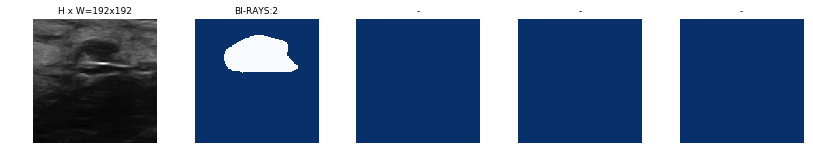

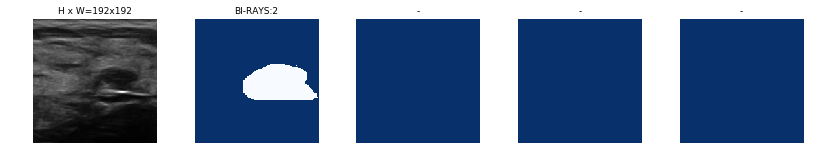

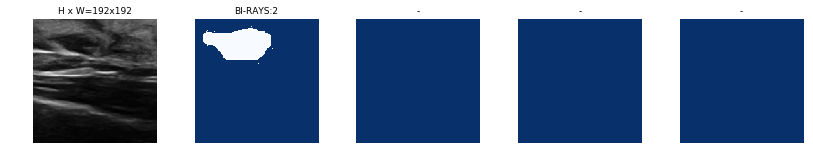

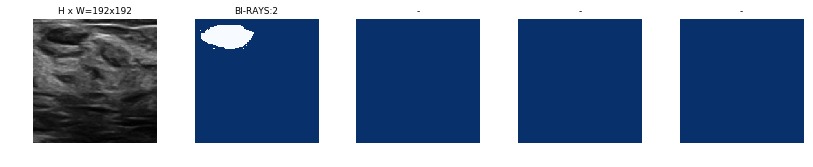

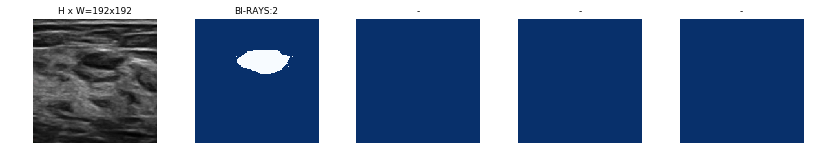

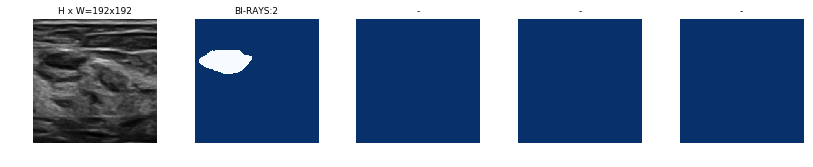

C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid\2
BI-RAYS:2 Image Count:284-568
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid\3
BI-RAYS:3 Image Count:283-645
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid\4
BI-RAYS:4 Image Count:276-744
=== valid data ===


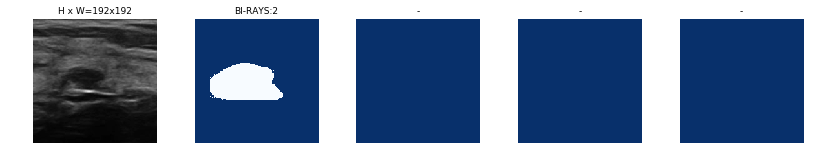

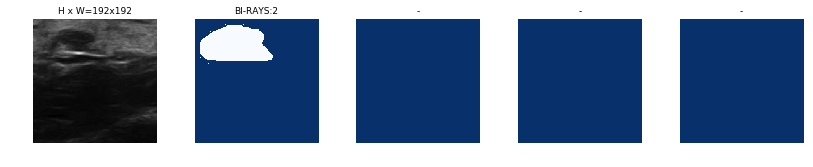

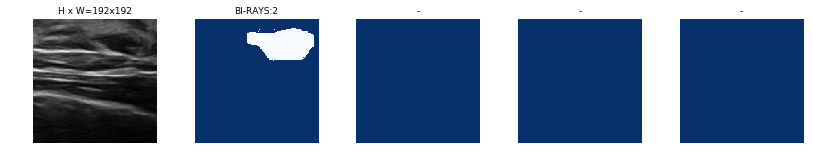

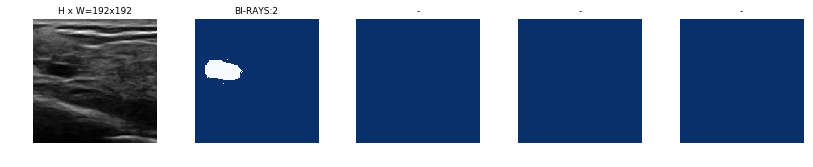

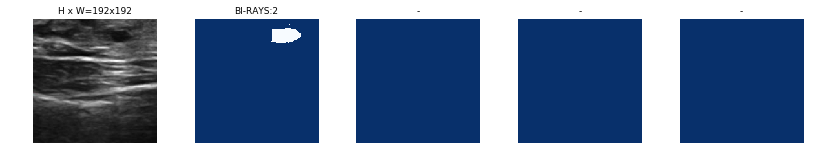

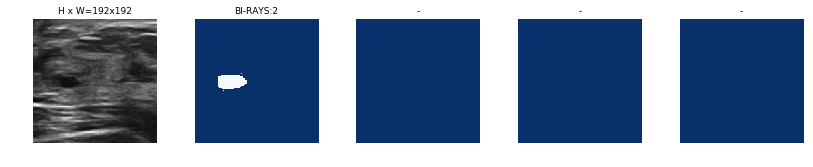

In [5]:
import cv2
from os import path
from os.path import join 

class BreastUltrasoundDataset(utils.Dataset):
    IMAGE_WIDTH = 192
    IMAGE_HEIGHT = 192
    
    def inital_dataset(self, data_set):   
        self.Is_HS = True
        # Add classes
        self.add_class("breast_ultrasound", 1, "BI-RAYS:2")       
        self.add_class("breast_ultrasound", 2, "BI-RAYS:3")
        self.add_class("breast_ultrasound", 3, "BI-RAYS:4")
         
        img_count = 0
        for bi_rays in ['2','3','4']:
            img_count = 0
            bi_rays_path = join(data_set, bi_rays)             
            print (bi_rays_path)
            file_names = next(os.walk(bi_rays_path))[2]             
            for index, file in enumerate(file_names):
                if file.endswith('.jpg') and "_mask" not in file:
                    split_file = file.split('.')
                    mask_file = split_file[0]+"_mask."+split_file[1]  
                    mask_file = join(bi_rays_path, mask_file)                     
                    if path.exists(mask_file):
                        self.add_image("breast_ultrasound", image_id=index, \
                                      path=os.path.join(bi_rays_path, file), \
                                      birays=int(bi_rays)-1)    
                        img_count+=1
            print ("BI-RAYS:{} Image Count:{}-{}".format(bi_rays, img_count, len(file_names)))
     
    def load_image(self, image_id):      
        info = self.image_info[image_id] 
        img = None
        if os.path.exists(info['path']):       
            img = cv2.imread(info['path'])
            img = cv2.resize(img, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            if self.Is_HS:                
                min_gray = np.min(img)
                max_gray = np.max(img)
                #print (img[0][:10])
                #print (min_gray, max_gray)
                scale = 255 / (max_gray-min_gray)
                #print (scale)
                trasfor_img = (img - min_gray)
                img = trasfor_img * scale
                img = img.astype(int)
                #print (img[0][:10])
        return img
      
    def get_imag_path(self, image_id):
        info = self.image_info[image_id] 
        return  info['birays'], info['path']
    
    
    def image_reference(self, image_id):        
        info = self.image_info[image_id]
        if info["source"] == "breast_ultrasound":
            return info["breast_ultrasound"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        info = self.image_info[image_id]  
        img = None
        orig_path = info['path']
        dot_index = orig_path.rfind('.')
        mask_path = orig_path[0:dot_index] + '_mask' + orig_path[dot_index:]    
        
        birays = info['birays']
        class_ids = [birays] 
        mask_lists=[]
        if os.path.exists(mask_path):  
            mask = cv2.imread(mask_path)     
            mask = cv2.resize(mask, (self.IMAGE_WIDTH, self.IMAGE_HEIGHT))
            mask =cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)                 
            mask_lists=[mask.astype(np.bool)]            
        
        mask = np.stack(mask_lists, axis=-1)         
        return mask, np.array(class_ids).astype(np.int32)
         
data_set = BreastUltrasoundDataset() 
data_set.inital_dataset(TRAIN_IMAGE_DIR)
data_set.prepare()

print ('=== train data ===')
for image_id in [0, 1, 2]:
    image = data_set.load_image(image_id)      
    mask, class_ids = data_set.load_mask(image_id)     
    visualize.display_top_masks(image, mask, class_ids, data_set.class_names) 

for image_id in [50 , 51, 52]:
    image = data_set.load_image(image_id)
    mask, class_ids = data_set.load_mask(image_id)     
    visualize.display_top_masks(image, mask, class_ids, data_set.class_names) 
    
valid_data_set = BreastUltrasoundDataset()
valid_data_set.inital_dataset(VALID_IMAGE_DIR)
valid_data_set.prepare()
print ('=== valid data ===')
for image_id in [0,1,2]:
    image = valid_data_set.load_image(image_id)      
    mask, class_ids = valid_data_set.load_mask(image_id)     
    visualize.display_top_masks(image, mask, class_ids, valid_data_set.class_names)     
    
for image_id in[80, 81, 82]:
    image = valid_data_set.load_image(image_id)      
    mask, class_ids = valid_data_set.load_mask(image_id)     
    visualize.display_top_masks(image, mask, class_ids, valid_data_set.class_names) 

In [6]:
img_len = len(data_set.image_ids)
image_mean = 0
for image_id in range(img_len):
    image = data_set.load_image(image_id)      
    image_mean = image_mean + np.mean(image)    
image_mean = image_mean / img_len
print (image_mean)

57.10959906173006


In [7]:
np.random.seed(7718)

# Create model object in inference mode. inference training
model = modellib.MaskRCNN(mode="training", model_dir=MODEL_DIR, config=config)

# Which weights to start with?
init_with = "last" # imagenet, coco, or last

if init_with == "last":
    print (model.find_last())
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_0211.h5
Re-starting from epoch 211


In [8]:
#from keras.callbacks import ModelCheckpoint
#from os.path import join

# Callbacks
#mycustom = ModelCheckpoint(join(MODEL_DIR, 'breast_ultrasound.hdf5'), monitor='val_loss', 
#                verbose=0, save_best_only=True, save_weights_only=False, 
#                mode='auto', period=1)
# custom_callbacks = [mycustom]

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(data_set, valid_data_set, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=1, 
            layers="all",           
            ) #"heads" "all"


Starting at epoch 211. LR=0.0001

Checkpoint Path: C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)

C:\Users\Yuan\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [9]:
# mixed original and mask image to mixed image
def display_mixed_image(img_path, IMAGE_WIDTH, IMAGE_HEIGHT):
    img = cv2.imread(img_path)     
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)                 
    
    dot_index = img_path.rfind('.')
    mask_path = img_path[0:dot_index] + '_mask' + img_path[dot_index:]  
    mask_img = cv2.imread(mask_path)     
    mask_img = cv2.resize(mask_img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    mask_img = cv2.cvtColor(mask_img, cv2.COLOR_BGR2GRAY)   
    mixed_image = cv2.addWeighted(img, 0.7 , mask_img, 0.3,0)

    # Create figure and axes
    fig, ax = plt.subplots(1, figsize=(7, 7))
    # Hide grid lines
    ax.grid(False)

    # Hide axes ticks
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.imshow(mixed_image, cmap=plt.cm.gray)
    ax.imshow(mixed_image, cmap=plt.cm.gray)
    
    # Create a Rectangle patch   
    #for rect in detect_rect:
    #    rect = patches.Rectangle(rect, SPLIT_IMAGE_COLUMN , SPLIT_IMAGE_ROW, linewidth=1,edgecolor='r',facecolor='none')
        # Add the patch to the Axes
    #    ax.add_patch(rect)
    plt.show()


In [10]:
class InferenceConfig2(InferenceConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1 
    BATCH_SIZE = 1

config2 = InferenceConfig2()

model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config2)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()
print (model_path)

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_0211.h5
Loading weights from  C:\Users\Yuan\Desktop\breast_mask_rcnn_\logs\breast_ultrasound20190122T1346\mask_rcnn_breast_ultrasound_0211.h5
Re-starting from epoch 211


bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train\2\BIRADS_2_md00_Image_005_0113015916.jpg
Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  254.00000  int32
molded_images            shape: (1, 192, 192, 3)      min:  -57.22000  max:  196.78000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train\2\BIRADS_2_md00_Image_005_0113015916.jpg
實際的位置與BI-RYAS : 2


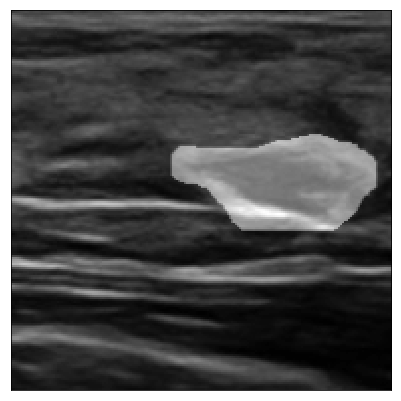

預測的位置與BI-RYAS:  [2 4] [0.9991359  0.77223957]


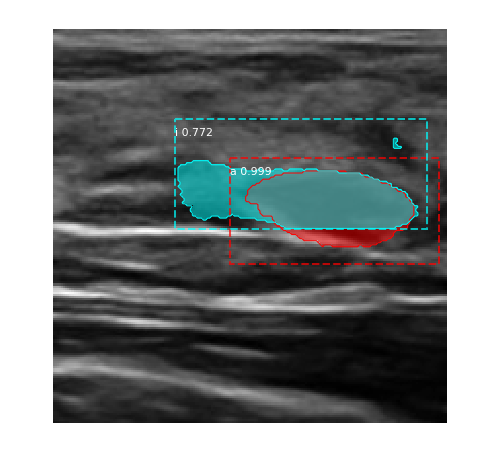

In [11]:

image_id=3
image = data_set.load_image(image_id) 
bi_rays, image_path = data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))

results = model.detect([image], verbose=1)


bi_rays, image_path = data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))
print ('實際的位置與BI-RYAS :',bi_rays+1)
display_mixed_image(image_path, 192, 192)

r = results[0]
print ('預測的位置與BI-RYAS: ', r['class_ids']+1, r['scores'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           'valid', r['scores'], figsize=(8, 8) ) #ax=get_ax()

bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train\2\BIRADS_2_md0468_Image_012_left_0121041019.jpg
Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  254.00000  int32
molded_images            shape: (1, 192, 192, 3)      min:  -57.22000  max:  196.78000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/train\2\BIRADS_2_md0468_Image_012_left_0121041019.jpg
實際的位置與BI-RYAS : 2


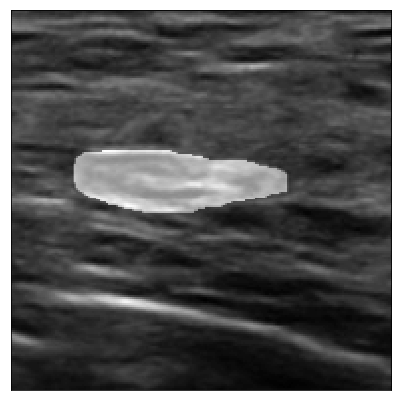

預測的位置與BI-RYAS:  [2 2] [0.95929193 0.8164525 ]


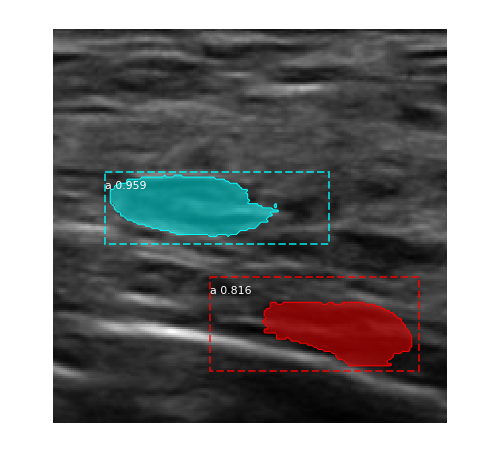

In [12]:

image_id=300
image = data_set.load_image(image_id) 
bi_rays, image_path = data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))

results = model.detect([image], verbose=1)


bi_rays, image_path = data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))
print ('實際的位置與BI-RYAS :',bi_rays+1)
display_mixed_image(image_path, 192, 192)

r = results[0]
print ('預測的位置與BI-RYAS: ', r['class_ids']+1, r['scores'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           'valid', r['scores'], figsize=(8, 8) ) #ax=get_ax()

bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid\2\BIRADS_2_md00_Image_007_0113020143.jpg
Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 192, 192, 3)      min:  -57.22000  max:  197.78000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid\2\BIRADS_2_md00_Image_007_0113020143.jpg
實際的位置與BI-RYAS : 2


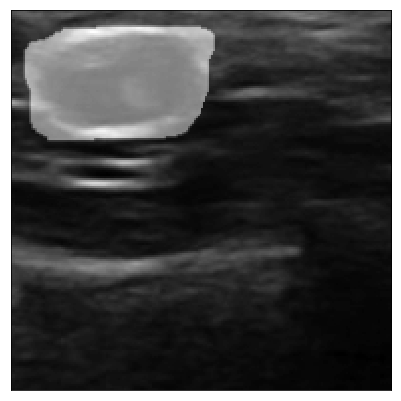

預測的位置與BI-RYAS:  [2 3] [0.9939367 0.7674274]


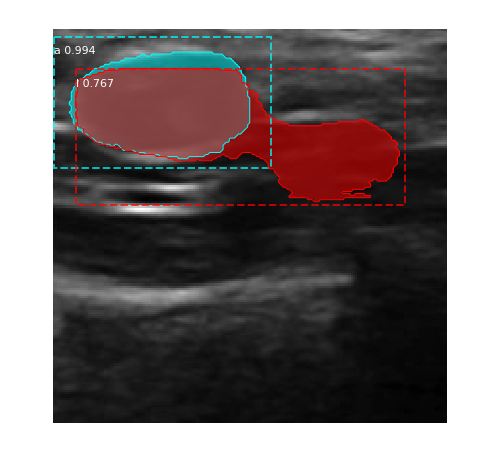

In [ ]:

image_id=3
image = valid_data_set.load_image(image_id) 
bi_rays, image_path = valid_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))

results = model.detect([image], verbose=1)


bi_rays, image_path = valid_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))
print ('實際的位置與BI-RYAS :',bi_rays+1)
display_mixed_image(image_path, 192, 192)

r = results[0]
print ('預測的位置與BI-RYAS: ', r['class_ids']+1, r['scores'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           'valid', r['scores'], figsize=(8, 8) ) #ax=get_ax()

bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid\2\BIRADS_2_md0432_Image_011_0113030550.jpg
Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  254.00000  int32
molded_images            shape: (1, 192, 192, 3)      min:  -57.22000  max:  196.78000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/valid\2\BIRADS_2_md0432_Image_011_0113030550.jpg
實際的位置與BI-RYAS : 2


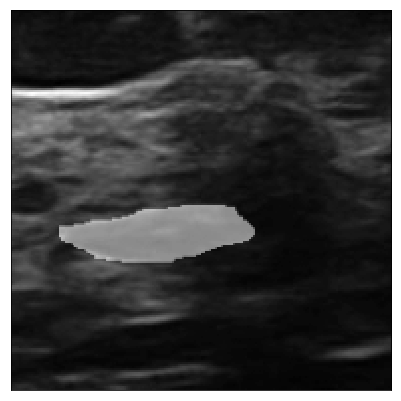

預測的位置與BI-RYAS:  [2] [0.9821077]


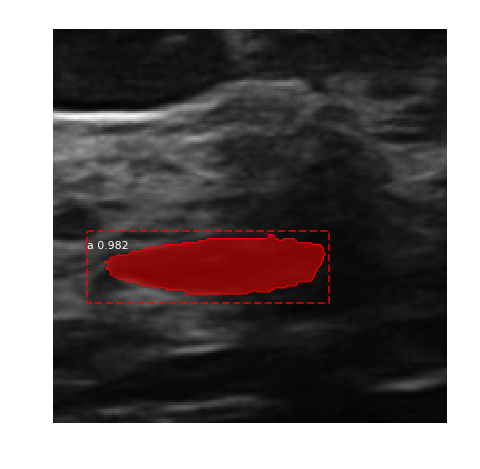

In [14]:

image_id=100
image = valid_data_set.load_image(image_id) 
bi_rays, image_path = valid_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))

results = model.detect([image], verbose=1)


bi_rays, image_path = valid_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))
print ('實際的位置與BI-RYAS :',bi_rays+1)
display_mixed_image(image_path, 192, 192)

r = results[0]
print ('預測的位置與BI-RYAS: ', r['class_ids']+1, r['scores'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           'valid', r['scores'], figsize=(8, 8) ) #ax=get_ax()


Test IMAGE DIR :  C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\2
BI-RAYS:2 Image Count:159-318
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\3
BI-RAYS:3 Image Count:122-244
C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\4
BI-RAYS:4 Image Count:35-70
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\2\BIRADS_2_md00_Image_005_0113015910.jpg
Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 192, 192, 3)      min:  -57.22000  max:  197.78000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
bi-rays:2 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\2\BIRADS_2_md00_Image_005_0113015910.jpg
實際的位置與BI-RYAS : 2


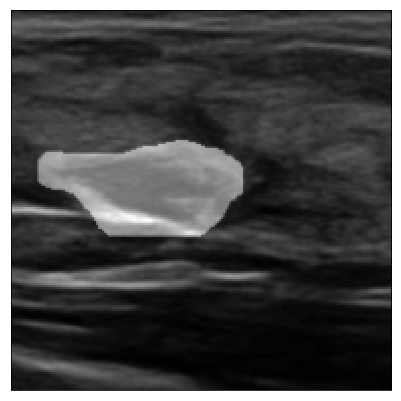

預測的位置與BI-RYAS:  [2 2 3 2] [0.9997389  0.9159028  0.79801273 0.78330594]


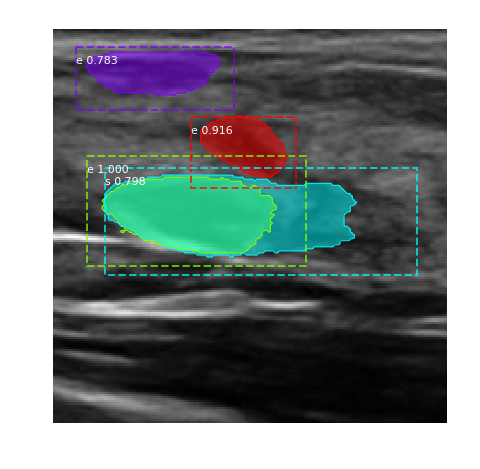

In [15]:

TEST_IMAGE_DIR = os.path.join(ROOT_DIR, "images/test")
print ('Test IMAGE DIR : ',TEST_IMAGE_DIR )

test_data_set = BreastUltrasoundDataset()
test_data_set.inital_dataset(TEST_IMAGE_DIR)
test_data_set.prepare()

image_id=1
image = test_data_set.load_image(image_id) 
bi_rays, image_path = test_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))

results = model.detect([image], verbose=1)


bi_rays, image_path = test_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))
print ('實際的位置與BI-RYAS :',bi_rays+1)
display_mixed_image(image_path, 192, 192)

r = results[0]
print ('預測的位置與BI-RYAS: ', r['class_ids']+1, r['scores'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           'test', r['scores'], figsize=(8, 8) ) #ax=get_ax()


 

Processing 1 images
image                    shape: (192, 192, 3)         min:    0.00000  max:  255.00000  int32
molded_images            shape: (1, 192, 192, 3)      min:  -57.22000  max:  197.78000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  192.00000  int32
anchors                  shape: (1, 9207, 4)          min:   -0.71081  max:    1.37573  float32
bi-rays:4 path:C:\Users\Yuan\Desktop\breast_mask_rcnn_\images/test\4\BIRADS_4_md025_Image_006_right_0123030510.jpg
實際的位置與BI-RYAS : 4


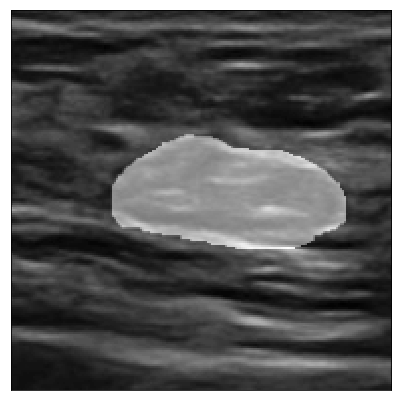

預測的位置與BI-RYAS:  [4 3 2] [0.93962747 0.8284448  0.7506576 ]


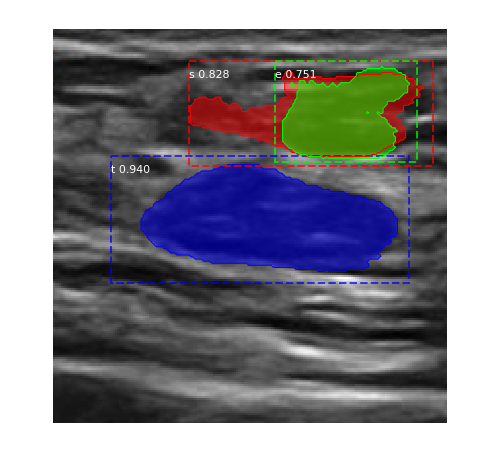

In [16]:

image_id=303
image = test_data_set.load_image(image_id)  
results = model.detect([image], verbose=1)

bi_rays, image_path = test_data_set.get_imag_path(image_id)
print ("bi-rays:{} path:{}".format(bi_rays+1, image_path))
print ('實際的位置與BI-RYAS :',bi_rays+1)
display_mixed_image(image_path, 192, 192)

r = results[0]
print ('預測的位置與BI-RYAS: ', r['class_ids']+1, r['scores'])
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                           'test', r['scores'], figsize=(8, 8) ) #ax=get_ax()
